In [2]:
import os
import shutil
import requests
import tarfile
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision.transforms as T
from torchvision import transforms

import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




/home/shirmord/.conda/envs/firstEnv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Extracting Images

In [ ]:
BASE_DIR      = Path("./data")
archive_path  = BASE_DIR / "lfw-funneled.tgz"
extract_to    = BASE_DIR / "lfw"

BASE_DIR.mkdir(exist_ok=True)

# Try live HTTPS first, then archive if that fails
urls = [
    "https://web.archive.org/web/20241214060830/"
]

for url in urls:
    try:
        print(f"Downloading from {url} …")
        resp = requests.get(url, stream=True, timeout=10)
        resp.raise_for_status()
        with open(archive_path, "wb") as f:
            for chunk in resp.iter_content(8192):
                f.write(chunk)
        print("Download succeeded.")
        break
    except Exception as e:
        print(f"  → failed: {e}")
else:
    raise RuntimeError("All download attempts failed.")

# Verify and extract
import tarfile
if not tarfile.is_tarfile(archive_path):
    raise RuntimeError(f"{archive_path} is not a valid tar archive!")
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_to)
print("Extraction complete.")


  → failed: HTTPSConnectionPool(host='vis-www.cs.umass.edu', port=443): Max retries exceeded with url: /lfw/lfw-funneled.tgz (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7fec0cb79300>: Failed to resolve 'vis-www.cs.umass.edu' ([Errno -2] Name or service not known)"))
Download succeeded.
Extraction complete.


In [ ]:

# ─── CONFIGURE THESE ───────────────────────────────────────────────────────────
# 1. Where did you extract LFW? (should contain one subfolder per person)
SRC_DIR     = Path("/home/shirmord/hw/data/lfw/lfw_funneled")  
# 2. Where are your parsed CSVs?
TEST_CSV   = Path("/home/shirmord/hw/parsed_test.csv")
TRAIN_CSV    = Path("/home/shirmord/hw/parsed_train.csv")
# 3. Where to write the split folders?
OUT_BASE    = Path("/home/shirmord/hw/hw2/lfw_split")
# ────────────────────────────────────────────────────────────────────────────────

# Read the train/test lists
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

def collect_filenames(df):
    """Given a DataFrame with name_1,image_1,name_2,image_2, return a set of all JPEG filenames."""
    names = set()
    for _, row in df.iterrows():
        n1, i1 = row["name_1"], int(row["image_1"])
        n2, i2 = row["name_2"], int(row["image_2"])
        names.add(f"{n1}_{i1:04d}.jpg")
        names.add(f"{n2}_{i2:04d}.jpg")
    return names

train_images = collect_filenames(train_df)
test_images  = collect_filenames(test_df)

# Make output directories
train_out = OUT_BASE / "train"
test_out  = OUT_BASE / "test"
(train_out).mkdir(parents=True, exist_ok=True)
(test_out).mkdir(parents=True, exist_ok=True)

# Copy files
def copy_split(image_set, dst_base):
    for fname in image_set:
        # person = fname.split("_")[0]
        person = fname.rsplit("_", 1)[0]
        src_path = SRC_DIR / person / fname
        dst_dir  = dst_base / person
        dst_dir.mkdir(exist_ok=True)
        if src_path.exists():
            shutil.copy2(src_path, dst_dir / fname)
        else:
            print(f"⚠️  Missing file: {src_path}")

print(f"Copying {len(train_images)} images to {train_out}/…")
copy_split(train_images, train_out)

print(f"Copying {len(test_images)} images to {test_out}/…")
copy_split(test_images, test_out)

print("Done!")


Copying 3443 images to /home/shirmord/hw/hw2/lfw_split/train/…
Copying 1549 images to /home/shirmord/hw/hw2/lfw_split/test/…
Done!


### Image Distribution

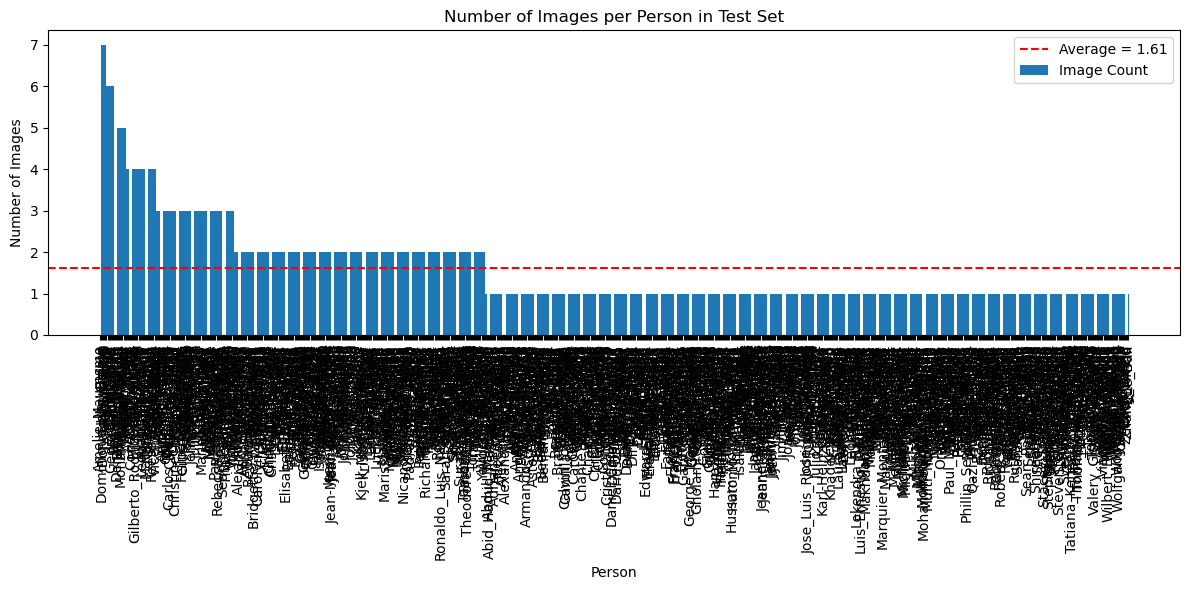

In [71]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Path to the test directory
test_dir = Path("/home/shirmord/hw/hw2/lfw_split/test")

# Dictionary to store counts per person
image_counts = {}

# Count the number of images per person
for person_dir in sorted(test_dir.iterdir()):
    if person_dir.is_dir():
        num_images = len(list(person_dir.glob("*.jpg")))
        image_counts[person_dir.name] = num_images

# Sort by number of images (descending)
image_counts = dict(sorted(image_counts.items(), key=lambda item: item[1], reverse=True))

# Compute average
average_count = sum(image_counts.values()) / len(image_counts)

# Plot the counts
plt.figure(figsize=(12, 6))
plt.bar(image_counts.keys(), image_counts.values(), label="Image Count")
plt.axhline(y=average_count, color='red', linestyle='--', label=f"Average = {average_count:.2f}")
plt.xticks(rotation=90)
plt.xlabel("Person")
plt.ylabel("Number of Images")
plt.title("Number of Images per Person in Test Set")
plt.legend()
plt.tight_layout()
plt.show()


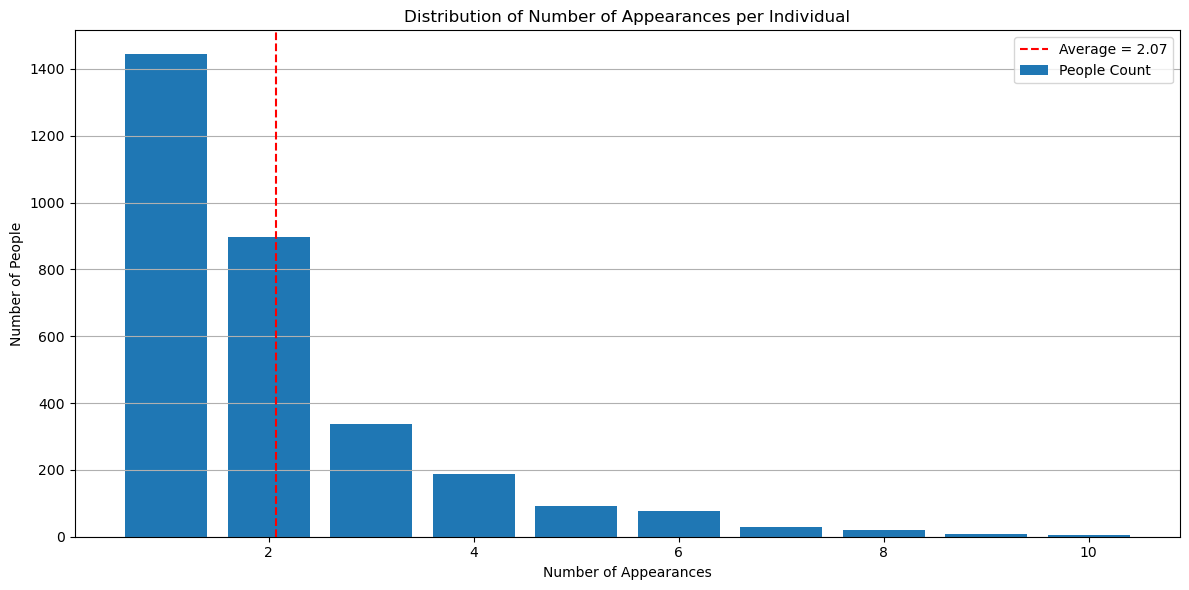

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

# Load the CSV files
train_csv = pd.read_csv("parsed_train.csv")
test_csv = pd.read_csv("parsed_test.csv")

# Combine train and test with a label
train_csv['split'] = 'train'
test_csv['split'] = 'test'
combined_df = pd.concat([train_csv, test_csv])

# Count occurrences of each person across both name_1 and name_2
all_names = pd.concat([combined_df['name_1'], combined_df['name_2']])
name_counts = Counter(all_names)

# Count how many people have each number of appearances
appearance_distribution = Counter(name_counts.values())
appearance_distribution = dict(sorted(appearance_distribution.items()))

# Prepare data for plotting
x_vals = list(appearance_distribution.keys())
y_vals = list(appearance_distribution.values())

# Compute average number of appearances per person
total_appearances = sum(count * freq for count, freq in appearance_distribution.items())
total_people = sum(y_vals)
average_appearances = total_appearances / total_people

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x_vals, y_vals, label="People Count")
plt.axvline(x=average_appearances, color='red', linestyle='--', label=f'Average = {average_appearances:.2f}')
plt.xlabel("Number of Appearances")
plt.ylabel("Number of People")
plt.title("Distribution of Number of Appearances per Individual")
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()



### Data Loading

In [3]:
from PIL import Image
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset

# ─── load images ────────────────────────────────
class LFWImagePairDataset(Dataset):
    """
    Loads two JPGs, returns them as PIL Images + the label.
    No transforms here – those are applied in the wrapper.
    """
    def __init__(self, csv_path: str, images_root: str):
        self.df   = pd.read_csv(csv_path)
        self.root = Path(images_root)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        n1, i1 = row["name_1"], int(row["image_1"])
        n2, i2 = row["name_2"], int(row["image_2"])

        p1 = self.root / n1 / f"{n1}_{i1:04d}.jpg"   # ← JPG!
        p2 = self.root / n2 / f"{n2}_{i2:04d}.jpg"

        img1 = Image.open(p1).convert("L")  # 1-channel grayscale
        img2 = Image.open(p2).convert("L")

        label = int(row["posative_pair"])
        return (img1, img2), label

# ─── define two transform pipelines ────────────────────────────────
train_transform = transforms.Compose([
    transforms.CenterCrop(190),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.CenterCrop(190),
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class TransformedPairDataset(Dataset):
    def __init__(self, base_ds: Dataset, transform):
        self.base_ds  = base_ds
        self.transform = transform

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        (img1, img2), label = self.base_ds[idx]
        return (self.transform(img1), self.transform(img2)), label

import random


# root folders still point at the original JPG hierarchy
TRAIN_ROOT = "/home/shirmord/hw/hw2/lfw_split/train"
TEST_ROOT  = "/home/shirmord/hw/hw2/lfw_split/test"

full_train_ds = LFWImagePairDataset(
    "/home/shirmord/hw/parsed_train.csv", TRAIN_ROOT
)

# split → Subset objects
train_raw, val_raw = torch.utils.data.random_split(
    full_train_ds,
    [int(len(full_train_ds)*0.8), int(len(full_train_ds)*0.2)],
    generator=torch.Generator().manual_seed(42)
)

test_raw = LFWImagePairDataset(
    "/home/shirmord/hw/parsed_test.csv", TEST_ROOT
)

total_train_size   = len(full_train_ds)
total_val_size     = int(total_train_size * 0.2)
total_train_size   = total_train_size - total_val_size
# ─── Transformations ───────────────────────────────────────────────────────
train_ds = TransformedPairDataset(train_raw, train_transform)
val_ds   = TransformedPairDataset(val_raw,   val_test_transform)
test_ds  = TransformedPairDataset(test_raw,  val_test_transform)

# ─── DataLoaders ───────────────────────────────────────────────────────
batch_size   = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# ── quick sanity check
print(f"Full train CSV contained {len(full_train_ds)} samples")
print(f" → using {total_train_size} for training, {total_val_size} for validation")
print(f"Test : {len(test_ds)} samples")


Full train CSV contained 2200 samples
 → using 1760 for training, 440 for validation
Test : 1000 samples


### Data Sampling

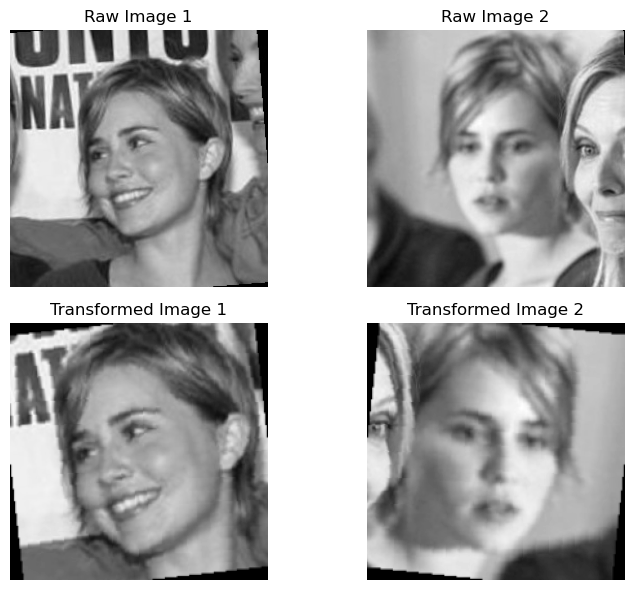

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

# Choose a random index (or fix it for reproducibility)
idx = 42

# Load raw (untransformed) images
(raw_img1, raw_img2), label = full_train_ds[idx]

# Define the transform pipeline
transform = transforms.Compose([
    transforms.CenterCrop(190),
    transforms.RandomHorizontalFlip(),  # ensure it always applies for demo
    transforms.RandomRotation(10),
    transforms.Resize((200, 200))
])

# Apply the transformation to both images
trans_img1 = transform(raw_img1)
trans_img2 = transform(raw_img2)

# Plot original and transformed images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes[0, 0].imshow(raw_img1, cmap='gray')
axes[0, 0].set_title("Raw Image 1")

axes[0, 1].imshow(raw_img2, cmap='gray')
axes[0, 1].set_title("Raw Image 2")

axes[1, 0].imshow(trans_img1, cmap='gray')
axes[1, 0].set_title("Transformed Image 1")

axes[1, 1].imshow(trans_img2, cmap='gray')
axes[1, 1].set_title("Transformed Image 2")

for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()


### Negative vs. Positive Distribution Analysis

In [18]:
from torch.utils.data import Subset

def labels_stratification(train_ds, val_ds, test_ds):
    def count_labels(ds):
        # 1) unwrap TransformedPairDataset if needed
        base = getattr(ds, "base_ds", ds)
        # 2) if it’s a Subset, pull from base.dataset.df & base.indices
        if isinstance(base, Subset):
            df      = base.dataset.df
            indices = base.indices
            labels  = df.iloc[indices]["posative_pair"]
        else:
            # otherwise it’s the full LFWTensorPairDataset
            df     = base.df
            labels = df["posative_pair"]

        same = int((labels == 1).sum())
        diff = int((labels == 0).sum())
        return same, diff

    train_1, train_0 = count_labels(train_ds)
    val_1,   val_0   = count_labels(val_ds)
    test_1,  test_0  = count_labels(test_ds)

    print("Train set:")
    print(f"\tPairs labeled as 1 (same individual):     {train_1}")
    print(f"\tPairs labeled as 0 (different individual: {train_0}\n")

    print("Validation set:")
    print(f"\tPairs labeled as 1 (same individual):     {val_1}")
    print(f"\tPairs labeled as 0 (different individual: {val_0}\n")

    print("Test set:")
    print(f"\tPairs labeled as 1 (same individual):     {test_1}")
    print(f"\tPairs labeled as 0 (different individual: {test_0}\n")

# ── Now just call it with your in-memory datasets ──────────────────────────
labels_stratification(train_ds, val_ds, test_ds)


Train set:
	Pairs labeled as 1 (same individual):     878
	Pairs labeled as 0 (different individual: 882

Validation set:
	Pairs labeled as 1 (same individual):     222
	Pairs labeled as 0 (different individual: 218

Test set:
	Pairs labeled as 1 (same individual):     500
	Pairs labeled as 0 (different individual: 500



### SiameseNetwork

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, fc1_dim,dropout_rate=0.0):
        super().__init__()
        # Shared convolutional tower
        self.conv1 = nn.Conv2d(1, 64, kernel_size=10)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
        # adjust here for resize×resize inputs:
        self.fc1   = nn.Linear(256 * fc1_dim * fc1_dim, 4096)
        self.fc2   = nn.Linear(4096, 1)

    def embedding(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)           # 160→151→75
        x = F.relu(self.conv2(x)); x = self.pool(x)           # 75→69→34
        x = F.relu(self.conv3(x)); x = self.pool(x)           # 34→31→15
        x = F.relu(self.conv4(x))                             # 15→12
        x = x.view(x.size(0), -1)                             # flatten 256×12×12 → 36864
        x = torch.sigmoid(self.fc1(x))                        # embedding
        return x

    def forward(self, img1, img2):
        e1 = self.embedding(img1)
        e2 = self.embedding(img2)
        diff = torch.abs(e1 - e2)                             # L1 distance
        score = torch.sigmoid(self.fc2(diff))
        return score


### Train

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_model(model, train_loader, val_loader, device,
                lr, optimizer_cls, weight_decay, num_epochs, patience):
    model = model.to(device)
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    best_val_loss = float('inf')
    best_state = None
    wait = 0

    # For plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    all_val_preds, all_val_labels = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_train_loss = 0.0
        correct_train, total_train = 0, 0

        for (x1, x2), labels in train_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
            optimizer.zero_grad()
            preds = model(x1, x2).squeeze()
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * x1.size(0)
            predicted = (preds >= 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        epoch_val_loss = 0.0
        correct_val, total_val = 0, 0

        val_preds_epoch, val_labels_epoch = [], []

        with torch.no_grad():
            for (x1, x2), labels in val_loader:
                x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
                preds = model(x1, x2).squeeze()
                epoch_val_loss += criterion(preds, labels).item() * x1.size(0)
                predicted = (preds >= 0.5).float()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                val_preds_epoch.extend(predicted.cpu().numpy())
                val_labels_epoch.extend(labels.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch} — Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} — "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            wait = 0
            all_val_preds = val_preds_epoch
            all_val_labels = val_labels_epoch
        elif epoch >= 50:
            break
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_state)

    # Compute confusion matrix
    cm = confusion_matrix(all_val_labels, all_val_preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix (Best Epoch):")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    # Plot loss and accuracy
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.subplot(1, 3, 3)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
    plt.title("Validation Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return model



### Optuna studies

In [ ]:
#  Optuna hyperparameter optimization
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['RMSprop', 'Adam', 'AdamW'])
    # use_bn        = trial.suggest_categorical("use_bn", [True, False])
    dropout_rate  = trial.suggest_float("dropout_rate", 0.0, 0.5)  # 0.0 ⇒ off

    # Prepare augmented training data
    
    # Choose optimizer class
    if optimizer_name == 'RMSprop':
        opt_cls = torch.optim.RMSprop
    elif optimizer_name == 'Adam':
        opt_cls = torch.optim.Adam
    else:
        opt_cls = torch.optim.AdamW

    # Build and train model
    # model = SiameseNetwork(dropout_rate=dropout_rate, use_bn=use_bn)
    model = SiameseNetwork(dropout_rate=dropout_rate)
    model = train_model(
        model, train_loader, val_loader, device,
        lr, opt_cls, weight_decay, num_epochs=200, patience=10
    )

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for (x1, x2), labels in val_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return 1.0 - accuracy  # minimize

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)

[I 2025-05-08 18:22:01,748] A new study created in memory with name: no-name-7e64d0f7-31d0-4acb-ba00-68501a9cb432
/tmp/ipykernel_473402/2843483109.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
/tmp/ipykernel_473402/2843483109.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)


Epoch 1 — Train Loss: 0.6731 — Val Loss: 0.6374
Epoch 2 — Train Loss: 0.6584 — Val Loss: 0.6326
Epoch 3 — Train Loss: 0.6385 — Val Loss: 0.6270
Epoch 4 — Train Loss: 0.6133 — Val Loss: 0.5960
Epoch 5 — Train Loss: 0.5833 — Val Loss: 0.6018
Epoch 6 — Train Loss: 0.5464 — Val Loss: 0.6313
Epoch 7 — Train Loss: 0.5221 — Val Loss: 0.5846
Epoch 8 — Train Loss: 0.4762 — Val Loss: 0.6076
Epoch 9 — Train Loss: 0.4373 — Val Loss: 0.5696
Epoch 10 — Train Loss: 0.3898 — Val Loss: 0.5950
Epoch 11 — Train Loss: 0.3489 — Val Loss: 0.6084
Epoch 12 — Train Loss: 0.3060 — Val Loss: 0.6135
Epoch 13 — Train Loss: 0.2605 — Val Loss: 0.5641
Epoch 14 — Train Loss: 0.2299 — Val Loss: 0.5823
Epoch 15 — Train Loss: 0.1853 — Val Loss: 0.6262
Epoch 16 — Train Loss: 0.1544 — Val Loss: 0.6717
Epoch 17 — Train Loss: 0.1444 — Val Loss: 0.6390
Epoch 18 — Train Loss: 0.1127 — Val Loss: 0.6255
Epoch 19 — Train Loss: 0.0908 — Val Loss: 0.6474
Epoch 20 — Train Loss: 0.0775 — Val Loss: 0.6587
Epoch 21 — Train Loss: 0.0656

[I 2025-05-08 20:25:09,916] Trial 0 finished with value: 0.2704545454545455 and parameters: {'lr': 7.505311686131538e-05, 'weight_decay': 4.417604043141827e-05, 'optimizer': 'AdamW', 'dropout_rate': 0.4711453028231614}. Best is trial 0 with value: 0.2704545454545455.


Epoch 1 — Train Loss: 0.6753 — Val Loss: 0.6486
Epoch 2 — Train Loss: 0.6488 — Val Loss: 0.6248
Epoch 3 — Train Loss: 0.6359 — Val Loss: 0.6281
Epoch 4 — Train Loss: 0.6122 — Val Loss: 0.5999
Epoch 5 — Train Loss: 0.5980 — Val Loss: 0.5995
Epoch 6 — Train Loss: 0.5677 — Val Loss: 0.5876
Epoch 7 — Train Loss: 0.5406 — Val Loss: 0.6211
Epoch 8 — Train Loss: 0.4943 — Val Loss: 0.5678
Epoch 9 — Train Loss: 0.4381 — Val Loss: 0.5847
Epoch 10 — Train Loss: 0.3865 — Val Loss: 0.5386
Epoch 11 — Train Loss: 0.3537 — Val Loss: 0.5381


### 105X105 run with best hyperparameters

Epoch 1 — Train Loss: 0.6928, Acc: 0.5011 — Val Loss: 0.6924, Acc: 0.4955
Epoch 2 — Train Loss: 0.6897, Acc: 0.5011 — Val Loss: 0.6878, Acc: 0.4977
Epoch 3 — Train Loss: 0.6811, Acc: 0.5136 — Val Loss: 0.6797, Acc: 0.5295
Epoch 4 — Train Loss: 0.6743, Acc: 0.5398 — Val Loss: 0.6687, Acc: 0.5455
Epoch 5 — Train Loss: 0.6641, Acc: 0.5693 — Val Loss: 0.6545, Acc: 0.5773
Epoch 6 — Train Loss: 0.6552, Acc: 0.5727 — Val Loss: 0.6468, Acc: 0.6068
Epoch 7 — Train Loss: 0.6485, Acc: 0.5915 — Val Loss: 0.6434, Acc: 0.6114
Epoch 8 — Train Loss: 0.6422, Acc: 0.6074 — Val Loss: 0.6413, Acc: 0.6205
Epoch 9 — Train Loss: 0.6349, Acc: 0.6170 — Val Loss: 0.6357, Acc: 0.6250
Epoch 10 — Train Loss: 0.6366, Acc: 0.6142 — Val Loss: 0.6324, Acc: 0.6295
Epoch 11 — Train Loss: 0.6255, Acc: 0.6381 — Val Loss: 0.6283, Acc: 0.6364
Epoch 12 — Train Loss: 0.6225, Acc: 0.6534 — Val Loss: 0.6282, Acc: 0.6273
Epoch 13 — Train Loss: 0.6193, Acc: 0.6574 — Val Loss: 0.6292, Acc: 0.6318
Epoch 14 — Train Loss: 0.6185, Acc

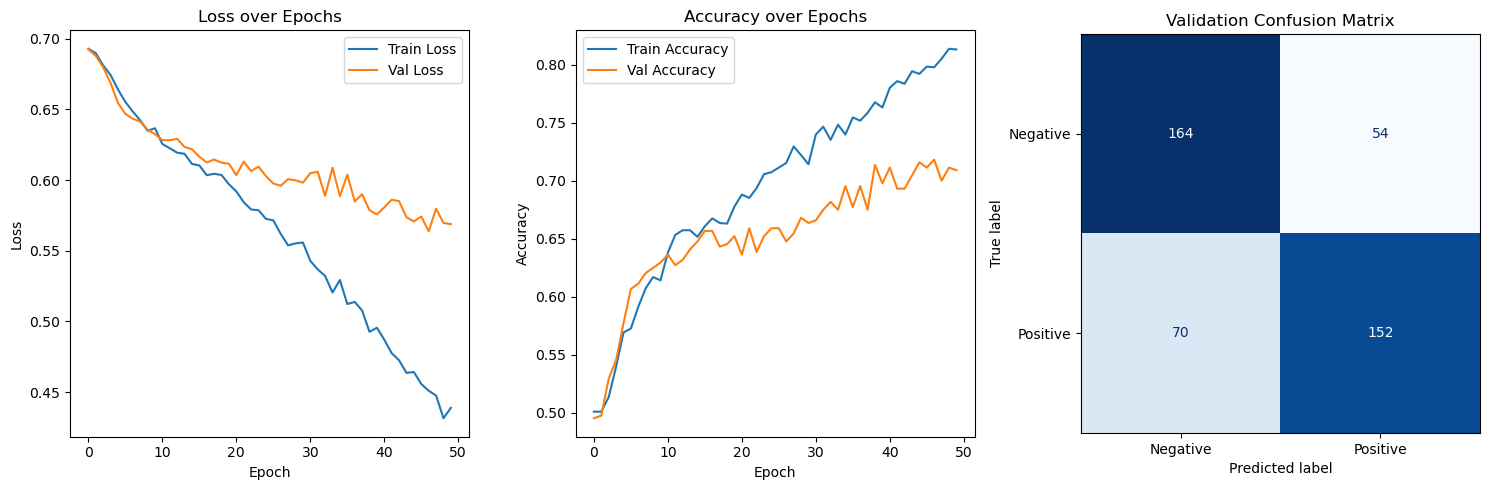

Validation accuracy: 0.7091


In [7]:
# Suggest hyperparameters
lr = 5.532550241526593e-06
weight_decay = 9.734368074308417e-05
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  =  0.3700110923609433
# Build and train model
model = SiameseNetwork(fc1_dim=6,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=20
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")



In [ ]:
# Suggest hyperparameters
lr = 1.9844109850514517e-06
weight_decay = 2.6973922090009065e-05
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  =  0.3687159808790628
# Build and train model
model = SiameseNetwork(fc1_dim=6,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=20
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")



In [7]:
def predict(model, test_loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct, total = 0, 0

    print("Running predictions on test set...")

    with torch.no_grad():
        for i, ((x1, x2), labels) in enumerate(test_loader):
            x1, x2 = x1.to(device), x2.to(device)
            labels = labels.to(device).float()

            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            print(f"Batch {i + 1}/{len(test_loader)} — Batch Accuracy: {batch_correct / labels.size(0):.4f}")

    final_acc = correct / total
    print(f"\nFinal Test Accuracy: {final_acc:.4f}")
    return all_preds, all_labels


predict(model, test_loader)

Running predictions on test set...
Batch 1/32 — Batch Accuracy: 0.5625
Batch 2/32 — Batch Accuracy: 0.5625
Batch 3/32 — Batch Accuracy: 0.6562
Batch 4/32 — Batch Accuracy: 0.6562
Batch 5/32 — Batch Accuracy: 0.4688
Batch 6/32 — Batch Accuracy: 0.6562
Batch 7/32 — Batch Accuracy: 0.4375
Batch 8/32 — Batch Accuracy: 0.7188
Batch 9/32 — Batch Accuracy: 0.5625
Batch 10/32 — Batch Accuracy: 0.5625
Batch 11/32 — Batch Accuracy: 0.5938
Batch 12/32 — Batch Accuracy: 0.5625
Batch 13/32 — Batch Accuracy: 0.6562
Batch 14/32 — Batch Accuracy: 0.5625
Batch 15/32 — Batch Accuracy: 0.6875
Batch 16/32 — Batch Accuracy: 0.6250
Batch 17/32 — Batch Accuracy: 0.6562
Batch 18/32 — Batch Accuracy: 0.7188
Batch 19/32 — Batch Accuracy: 0.7500
Batch 20/32 — Batch Accuracy: 0.7500
Batch 21/32 — Batch Accuracy: 0.7500
Batch 22/32 — Batch Accuracy: 0.7812
Batch 23/32 — Batch Accuracy: 0.7500
Batch 24/32 — Batch Accuracy: 0.8125
Batch 25/32 — Batch Accuracy: 0.6250
Batch 26/32 — Batch Accuracy: 0.7812
Batch 27/32 

([0.5542527,
  0.57343316,
  0.5405972,
  0.5698472,
  0.38137645,
  0.24931179,
  0.66986704,
  0.4058984,
  0.5989981,
  0.57081866,
  0.518718,
  0.38336733,
  0.3433256,
  0.37147966,
  0.5366917,
  0.53507173,
  0.5070487,
  0.5787085,
  0.4485646,
  0.4716077,
  0.5034039,
  0.46323618,
  0.4401187,
  0.67132866,
  0.43639925,
  0.6230957,
  0.48659796,
  0.33943084,
  0.34954906,
  0.5843538,
  0.6728585,
  0.5088006,
  0.49151012,
  0.5383641,
  0.5205162,
  0.35501087,
  0.49429044,
  0.55468106,
  0.5841357,
  0.6155137,
  0.67058283,
  0.27729675,
  0.45344546,
  0.50767064,
  0.58882385,
  0.46033987,
  0.5171445,
  0.6397036,
  0.5420474,
  0.6750465,
  0.25347695,
  0.42672044,
  0.5718195,
  0.6229084,
  0.34397,
  0.33638895,
  0.6638973,
  0.55860966,
  0.44648993,
  0.11703633,
  0.27547792,
  0.75352,
  0.6098928,
  0.45478883,
  0.44355786,
  0.575705,
  0.55522263,
  0.51061106,
  0.7022589,
  0.5103109,
  0.6381958,
  0.6275252,
  0.24692401,
  0.66352224,
  0.606

### 160x160 run with best hyperparameters

Epoch 1 — Train Loss: 0.6928, Acc: 0.5011 — Val Loss: 0.6912, Acc: 0.4955
Epoch 2 — Train Loss: 0.6787, Acc: 0.5136 — Val Loss: 0.6594, Acc: 0.5568
Epoch 3 — Train Loss: 0.6689, Acc: 0.5716 — Val Loss: 0.6412, Acc: 0.6000
Epoch 4 — Train Loss: 0.6528, Acc: 0.5920 — Val Loss: 0.6541, Acc: 0.6136
Epoch 5 — Train Loss: 0.6463, Acc: 0.6114 — Val Loss: 0.6372, Acc: 0.6159
Epoch 6 — Train Loss: 0.6448, Acc: 0.6045 — Val Loss: 0.6377, Acc: 0.6386
Epoch 7 — Train Loss: 0.6412, Acc: 0.6227 — Val Loss: 0.6230, Acc: 0.6341
Epoch 8 — Train Loss: 0.6325, Acc: 0.6290 — Val Loss: 0.6088, Acc: 0.6568
Epoch 9 — Train Loss: 0.6281, Acc: 0.6403 — Val Loss: 0.6127, Acc: 0.6295
Epoch 10 — Train Loss: 0.6263, Acc: 0.6318 — Val Loss: 0.6323, Acc: 0.6159
Epoch 11 — Train Loss: 0.6228, Acc: 0.6409 — Val Loss: 0.6168, Acc: 0.6318
Epoch 12 — Train Loss: 0.6222, Acc: 0.6318 — Val Loss: 0.6034, Acc: 0.6773
Epoch 13 — Train Loss: 0.6059, Acc: 0.6676 — Val Loss: 0.5763, Acc: 0.7091
Epoch 14 — Train Loss: 0.6016, Acc

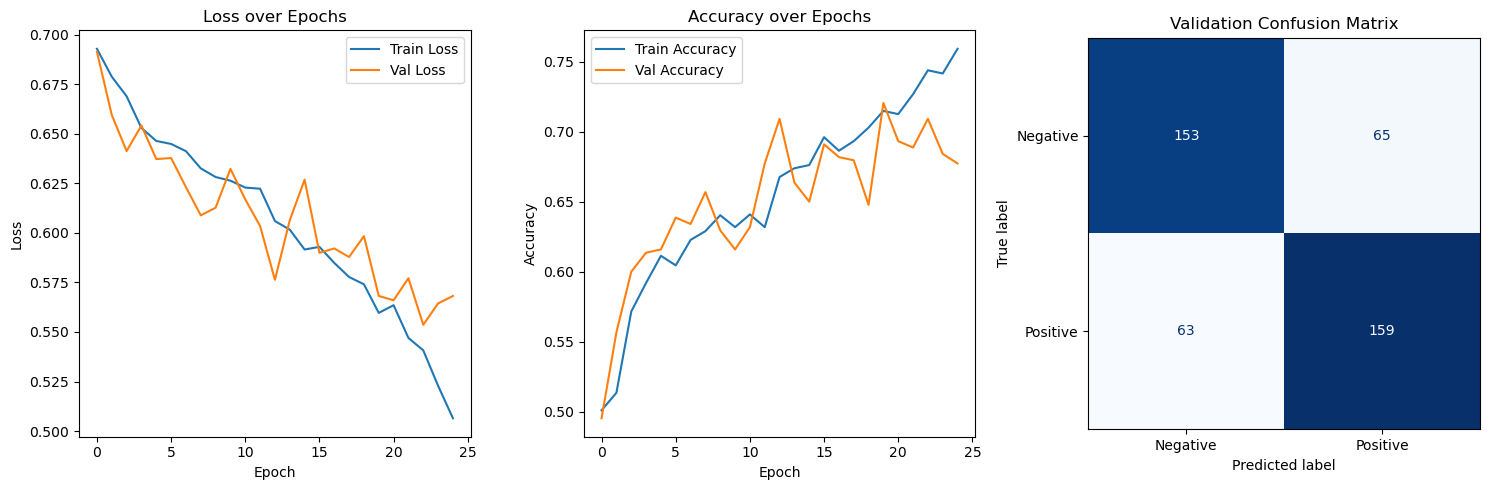

Validation accuracy: 0.6773


In [9]:

# Suggest hyperparameters
lr = 4.08367006057259e-05
weight_decay = 0.008757687339341956
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  = 0.3357751894656019
# Build and train model
model = SiameseNetwork(fc1_dim=12,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=20
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")


In [10]:
def predict(model, test_loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct, total = 0, 0

    print("Running predictions on test set...")

    with torch.no_grad():
        for i, ((x1, x2), labels) in enumerate(test_loader):
            x1, x2 = x1.to(device), x2.to(device)
            labels = labels.to(device).float()

            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            print(f"Batch {i + 1}/{len(test_loader)} — Batch Accuracy: {batch_correct / labels.size(0):.4f}")

    final_acc = correct / total
    print(f"\nFinal Test Accuracy: {final_acc:.4f}")
    return all_preds, all_labels


predict(model, test_loader)

Running predictions on test set...
Batch 1/32 — Batch Accuracy: 0.6250
Batch 2/32 — Batch Accuracy: 0.4062
Batch 3/32 — Batch Accuracy: 0.5625
Batch 4/32 — Batch Accuracy: 0.6562
Batch 5/32 — Batch Accuracy: 0.5000
Batch 6/32 — Batch Accuracy: 0.6250
Batch 7/32 — Batch Accuracy: 0.5625
Batch 8/32 — Batch Accuracy: 0.4375
Batch 9/32 — Batch Accuracy: 0.5000
Batch 10/32 — Batch Accuracy: 0.5312
Batch 11/32 — Batch Accuracy: 0.5000
Batch 12/32 — Batch Accuracy: 0.5938
Batch 13/32 — Batch Accuracy: 0.6250
Batch 14/32 — Batch Accuracy: 0.5000
Batch 15/32 — Batch Accuracy: 0.7188
Batch 16/32 — Batch Accuracy: 0.6250
Batch 17/32 — Batch Accuracy: 0.6875
Batch 18/32 — Batch Accuracy: 0.9375
Batch 19/32 — Batch Accuracy: 0.8438
Batch 20/32 — Batch Accuracy: 0.7188
Batch 21/32 — Batch Accuracy: 0.9375
Batch 22/32 — Batch Accuracy: 0.8750
Batch 23/32 — Batch Accuracy: 0.7500
Batch 24/32 — Batch Accuracy: 0.8438
Batch 25/32 — Batch Accuracy: 0.7188
Batch 26/32 — Batch Accuracy: 0.8438
Batch 27/32 

([0.54331213,
  0.5747377,
  0.7495775,
  0.5595677,
  0.51935893,
  0.2041825,
  0.6207596,
  0.7007166,
  0.6948055,
  0.6410305,
  0.6761028,
  0.48403326,
  0.38873503,
  0.55105567,
  0.36920357,
  0.6957995,
  0.7442058,
  0.4054466,
  0.7719744,
  0.6562178,
  0.87038934,
  0.45054048,
  0.26914304,
  0.6402507,
  0.35626256,
  0.3276672,
  0.3152962,
  0.53395534,
  0.23847109,
  0.4777878,
  0.7638413,
  0.6661892,
  0.6299728,
  0.29752445,
  0.3789632,
  0.49272144,
  0.57302636,
  0.43603414,
  0.41165918,
  0.7417785,
  0.5446401,
  0.18477121,
  0.41943526,
  0.34905738,
  0.3685594,
  0.5812273,
  0.27480575,
  0.62938714,
  0.55078614,
  0.7219339,
  0.39946446,
  0.69678146,
  0.6115616,
  0.40382513,
  0.47177145,
  0.267369,
  0.27601397,
  0.39991915,
  0.66065943,
  0.43569717,
  0.4904503,
  0.38228014,
  0.64934886,
  0.633642,
  0.2801278,
  0.53918105,
  0.40070674,
  0.32632378,
  0.5680839,
  0.34744495,
  0.7495324,
  0.5553312,
  0.12222906,
  0.5918118,
  

### 200X200 run with best hyperparameters

Epoch 1 — Train Loss: 0.6828, Acc: 0.5602 — Val Loss: 0.6581, Acc: 0.5455
Epoch 2 — Train Loss: 0.6538, Acc: 0.5949 — Val Loss: 0.6313, Acc: 0.6500
Epoch 3 — Train Loss: 0.6495, Acc: 0.5943 — Val Loss: 0.6411, Acc: 0.6477
Epoch 4 — Train Loss: 0.6430, Acc: 0.6085 — Val Loss: 0.6164, Acc: 0.6864
Epoch 5 — Train Loss: 0.6340, Acc: 0.6295 — Val Loss: 0.6451, Acc: 0.6455
Epoch 6 — Train Loss: 0.6266, Acc: 0.6415 — Val Loss: 0.6046, Acc: 0.6432
Epoch 7 — Train Loss: 0.6191, Acc: 0.6602 — Val Loss: 0.5984, Acc: 0.7068
Epoch 8 — Train Loss: 0.6114, Acc: 0.6591 — Val Loss: 0.5956, Acc: 0.6955
Epoch 9 — Train Loss: 0.6062, Acc: 0.6818 — Val Loss: 0.6028, Acc: 0.6841
Epoch 10 — Train Loss: 0.5996, Acc: 0.6892 — Val Loss: 0.5880, Acc: 0.7045
Epoch 11 — Train Loss: 0.5932, Acc: 0.6966 — Val Loss: 0.5845, Acc: 0.7295
Epoch 12 — Train Loss: 0.5884, Acc: 0.6767 — Val Loss: 0.5785, Acc: 0.7045
Epoch 13 — Train Loss: 0.5699, Acc: 0.6983 — Val Loss: 0.5822, Acc: 0.6932
Epoch 14 — Train Loss: 0.5756, Acc

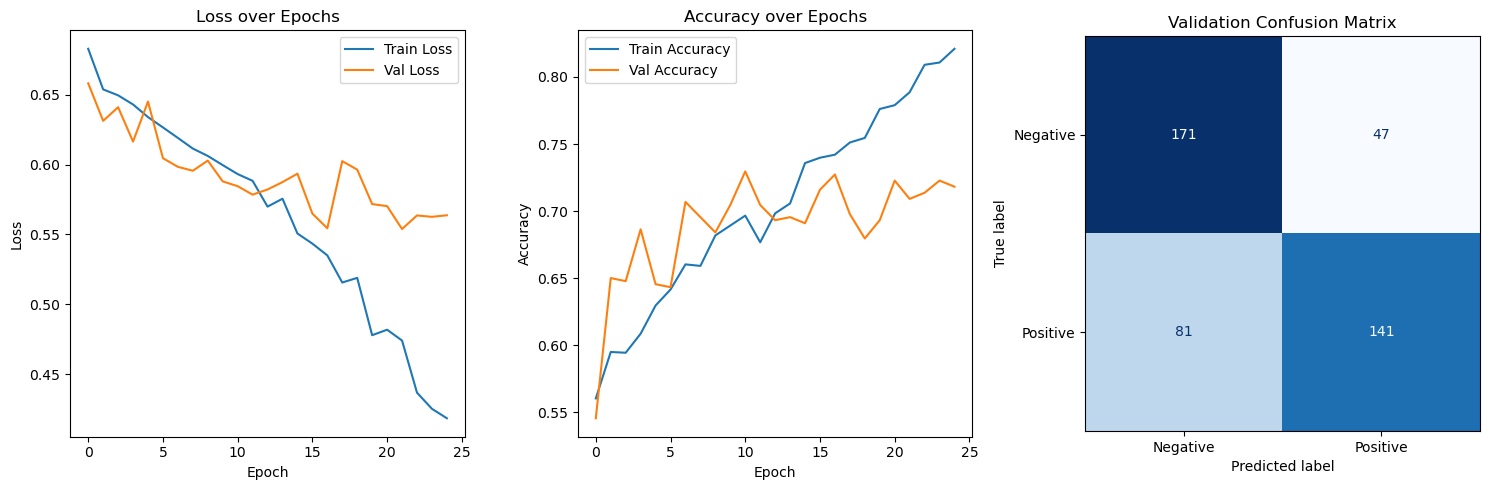

Validation accuracy: 0.7182


In [8]:
# Suggest hyperparameters
lr = 0.00022464196855043374
weight_decay = 0.0062398539519617465
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  = 0.3339944605059354
# Build and train model
model = SiameseNetwork(fc1_dim=17,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=20
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")


In [10]:
def predict(model, test_loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct, total = 0, 0

    print("Running predictions on test set...")

    with torch.no_grad():
        for i, ((x1, x2), labels) in enumerate(test_loader):
            x1, x2 = x1.to(device), x2.to(device)
            labels = labels.to(device).float()

            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            print(f"Batch {i + 1}/{len(test_loader)} — Batch Accuracy: {batch_correct / labels.size(0):.4f}")

    final_acc = correct / total
    print(f"\nFinal Test Accuracy: {final_acc:.4f}")
    return all_preds, all_labels


predict(model, test_loader)

Running predictions on test set...
Batch 1/32 — Batch Accuracy: 0.5312
Batch 2/32 — Batch Accuracy: 0.5625
Batch 3/32 — Batch Accuracy: 0.4375
Batch 4/32 — Batch Accuracy: 0.5938
Batch 5/32 — Batch Accuracy: 0.5938
Batch 6/32 — Batch Accuracy: 0.6562
Batch 7/32 — Batch Accuracy: 0.5938
Batch 8/32 — Batch Accuracy: 0.5312
Batch 9/32 — Batch Accuracy: 0.4375
Batch 10/32 — Batch Accuracy: 0.6562
Batch 11/32 — Batch Accuracy: 0.6250
Batch 12/32 — Batch Accuracy: 0.5312
Batch 13/32 — Batch Accuracy: 0.6562
Batch 14/32 — Batch Accuracy: 0.4062
Batch 15/32 — Batch Accuracy: 0.6562
Batch 16/32 — Batch Accuracy: 0.5938
Batch 17/32 — Batch Accuracy: 0.7500
Batch 18/32 — Batch Accuracy: 0.9375
Batch 19/32 — Batch Accuracy: 0.7188
Batch 20/32 — Batch Accuracy: 0.7188
Batch 21/32 — Batch Accuracy: 0.9375
Batch 22/32 — Batch Accuracy: 0.9062
Batch 23/32 — Batch Accuracy: 0.8438
Batch 24/32 — Batch Accuracy: 0.8750
Batch 25/32 — Batch Accuracy: 0.8125
Batch 26/32 — Batch Accuracy: 0.8438
Batch 27/32 

([0.23486501,
  0.5224557,
  0.65691245,
  0.3907721,
  0.21948317,
  0.028919619,
  0.74008316,
  0.7926486,
  0.76317215,
  0.3977488,
  0.8065642,
  0.5928758,
  0.1329033,
  0.48517692,
  0.38339922,
  0.6769078,
  0.6588688,
  0.4897183,
  0.57887214,
  0.4429292,
  0.8347754,
  0.42623436,
  0.20701982,
  0.8958514,
  0.4677211,
  0.5594071,
  0.5127191,
  0.6962886,
  0.17609276,
  0.46382585,
  0.6984377,
  0.7197574,
  0.49351233,
  0.54639596,
  0.43912464,
  0.31160492,
  0.8275409,
  0.5440841,
  0.4699137,
  0.77443594,
  0.7780163,
  0.561364,
  0.17171736,
  0.7096604,
  0.6521364,
  0.7449118,
  0.68241876,
  0.8272551,
  0.6500892,
  0.7349298,
  0.43058205,
  0.89428747,
  0.39600343,
  0.8212381,
  0.07650081,
  0.3193913,
  0.15672314,
  0.52552813,
  0.379748,
  0.47584233,
  0.46533412,
  0.44359273,
  0.6572932,
  0.8865011,
  0.33904848,
  0.44321743,
  0.39742777,
  0.43069312,
  0.7372302,
  0.36343402,
  0.66562307,
  0.39191002,
  0.2279187,
  0.8725046,
  0

## Appendixes 
(experiments we have conducted, not mentioned in the report)

##### 105X105 run with best hyperparameters & random augmentation

Epoch 1 — Train Loss: 0.6930, Acc: 0.5011 — Val Loss: 0.6927, Acc: 0.4955
Epoch 2 — Train Loss: 0.6877, Acc: 0.5068 — Val Loss: 0.6790, Acc: 0.5182
Epoch 3 — Train Loss: 0.6700, Acc: 0.5602 — Val Loss: 0.6687, Acc: 0.5386
Epoch 4 — Train Loss: 0.6628, Acc: 0.5801 — Val Loss: 0.6547, Acc: 0.6091
Epoch 5 — Train Loss: 0.6543, Acc: 0.5926 — Val Loss: 0.6460, Acc: 0.6068
Epoch 6 — Train Loss: 0.6525, Acc: 0.5949 — Val Loss: 0.6406, Acc: 0.6182
Epoch 7 — Train Loss: 0.6410, Acc: 0.6131 — Val Loss: 0.6252, Acc: 0.6341
Epoch 8 — Train Loss: 0.6435, Acc: 0.6080 — Val Loss: 0.6361, Acc: 0.6273
Epoch 9 — Train Loss: 0.6383, Acc: 0.6358 — Val Loss: 0.6308, Acc: 0.6250
Epoch 10 — Train Loss: 0.6333, Acc: 0.6307 — Val Loss: 0.6240, Acc: 0.6545
Epoch 11 — Train Loss: 0.6294, Acc: 0.6347 — Val Loss: 0.6177, Acc: 0.6568
Epoch 12 — Train Loss: 0.6289, Acc: 0.6381 — Val Loss: 0.6142, Acc: 0.6591
Epoch 13 — Train Loss: 0.6273, Acc: 0.6256 — Val Loss: 0.6219, Acc: 0.6636
Epoch 14 — Train Loss: 0.6258, Acc

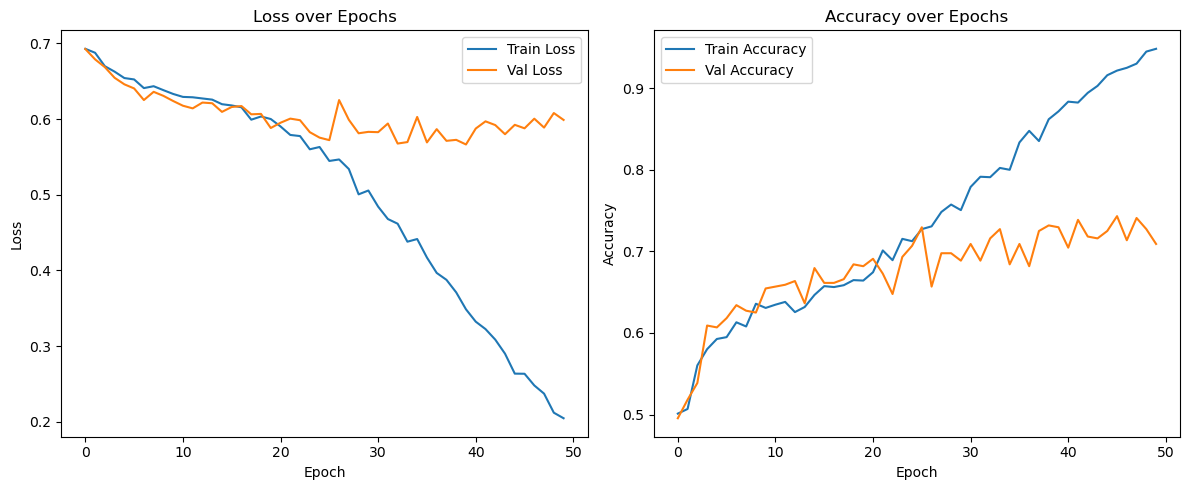

Validation accuracy: 0.7091


In [ ]:

# Suggest hyperparameters
lr = 4.08367006057259e-05
weight_decay = 0.008757687339341956
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  = 0.3357751894656019
# Build and train model
model = SiameseNetwork(fc1_dim=6,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=10
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")


In [ ]:
def predict(model, test_loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct, total = 0, 0

    print("Running predictions on test set...")

    with torch.no_grad():
        for i, ((x1, x2), labels) in enumerate(test_loader):
            x1, x2 = x1.to(device), x2.to(device)
            labels = labels.to(device).float()

            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            print(f"Batch {i + 1}/{len(test_loader)} — Batch Accuracy: {batch_correct / labels.size(0):.4f}")

    final_acc = correct / total
    print(f"\nFinal Test Accuracy: {final_acc:.4f}")
    return all_preds, all_labels


predict(model, test_loader)

Running predictions on test set...
Batch 1/32 — Batch Accuracy: 0.5000
Batch 2/32 — Batch Accuracy: 0.5000
Batch 3/32 — Batch Accuracy: 0.5625
Batch 4/32 — Batch Accuracy: 0.5625
Batch 5/32 — Batch Accuracy: 0.5625
Batch 6/32 — Batch Accuracy: 0.5938
Batch 7/32 — Batch Accuracy: 0.3438
Batch 8/32 — Batch Accuracy: 0.5938
Batch 9/32 — Batch Accuracy: 0.4375
Batch 10/32 — Batch Accuracy: 0.4062
Batch 11/32 — Batch Accuracy: 0.4688
Batch 12/32 — Batch Accuracy: 0.5000
Batch 13/32 — Batch Accuracy: 0.6562
Batch 14/32 — Batch Accuracy: 0.2812
Batch 15/32 — Batch Accuracy: 0.8125
Batch 16/32 — Batch Accuracy: 0.6875
Batch 17/32 — Batch Accuracy: 0.6562
Batch 18/32 — Batch Accuracy: 0.7812
Batch 19/32 — Batch Accuracy: 0.8125
Batch 20/32 — Batch Accuracy: 0.7812
Batch 21/32 — Batch Accuracy: 0.9375
Batch 22/32 — Batch Accuracy: 0.9375
Batch 23/32 — Batch Accuracy: 0.8438
Batch 24/32 — Batch Accuracy: 0.8750
Batch 25/32 — Batch Accuracy: 0.7500
Batch 26/32 — Batch Accuracy: 0.8750
Batch 27/32 

([0.46860597,
  0.43363512,
  0.52947176,
  0.42870238,
  0.39214393,
  0.19513531,
  0.72587144,
  0.45192182,
  0.67376965,
  0.6697773,
  0.5924813,
  0.48381093,
  0.21470621,
  0.2528616,
  0.43546876,
  0.523925,
  0.6534216,
  0.49856782,
  0.55217123,
  0.54233605,
  0.51669085,
  0.2144149,
  0.4049782,
  0.5518616,
  0.35619098,
  0.54799044,
  0.4925193,
  0.57526135,
  0.25291017,
  0.5139969,
  0.5806623,
  0.5902033,
  0.34802556,
  0.48600727,
  0.542339,
  0.63703257,
  0.6620192,
  0.41221508,
  0.47059742,
  0.61237484,
  0.6618841,
  0.18234812,
  0.41919854,
  0.4142868,
  0.36430362,
  0.48396328,
  0.56277263,
  0.6061094,
  0.61557376,
  0.7230463,
  0.2009639,
  0.5006672,
  0.48274213,
  0.5708792,
  0.18905291,
  0.15357973,
  0.5314699,
  0.52572435,
  0.45388213,
  0.22113062,
  0.57195103,
  0.45029208,
  0.571274,
  0.59938234,
  0.40321347,
  0.5524691,
  0.39852148,
  0.5124855,
  0.5869473,
  0.48303673,
  0.5881405,
  0.53329057,
  0.08890847,
  0.5729

##### 160x160 run with best hyperparameters & random augmentation

Epoch 1 — Train Loss: 0.6928, Acc: 0.5011 — Val Loss: 0.6912, Acc: 0.4955
Epoch 2 — Train Loss: 0.6740, Acc: 0.5489 — Val Loss: 0.6698, Acc: 0.5568
Epoch 3 — Train Loss: 0.6631, Acc: 0.5858 — Val Loss: 0.6404, Acc: 0.6045
Epoch 4 — Train Loss: 0.6510, Acc: 0.5972 — Val Loss: 0.6608, Acc: 0.6091
Epoch 5 — Train Loss: 0.6519, Acc: 0.6000 — Val Loss: 0.6412, Acc: 0.6159
Epoch 6 — Train Loss: 0.6389, Acc: 0.6290 — Val Loss: 0.6285, Acc: 0.6523
Epoch 7 — Train Loss: 0.6384, Acc: 0.6165 — Val Loss: 0.6251, Acc: 0.6455
Epoch 8 — Train Loss: 0.6326, Acc: 0.6330 — Val Loss: 0.6193, Acc: 0.6364
Epoch 9 — Train Loss: 0.6200, Acc: 0.6551 — Val Loss: 0.6082, Acc: 0.6841
Epoch 10 — Train Loss: 0.6192, Acc: 0.6449 — Val Loss: 0.6030, Acc: 0.6818
Epoch 11 — Train Loss: 0.6040, Acc: 0.6824 — Val Loss: 0.5918, Acc: 0.7136
Epoch 12 — Train Loss: 0.5979, Acc: 0.6795 — Val Loss: 0.5803, Acc: 0.6932
Epoch 13 — Train Loss: 0.5885, Acc: 0.6972 — Val Loss: 0.5899, Acc: 0.7000
Epoch 14 — Train Loss: 0.5847, Acc

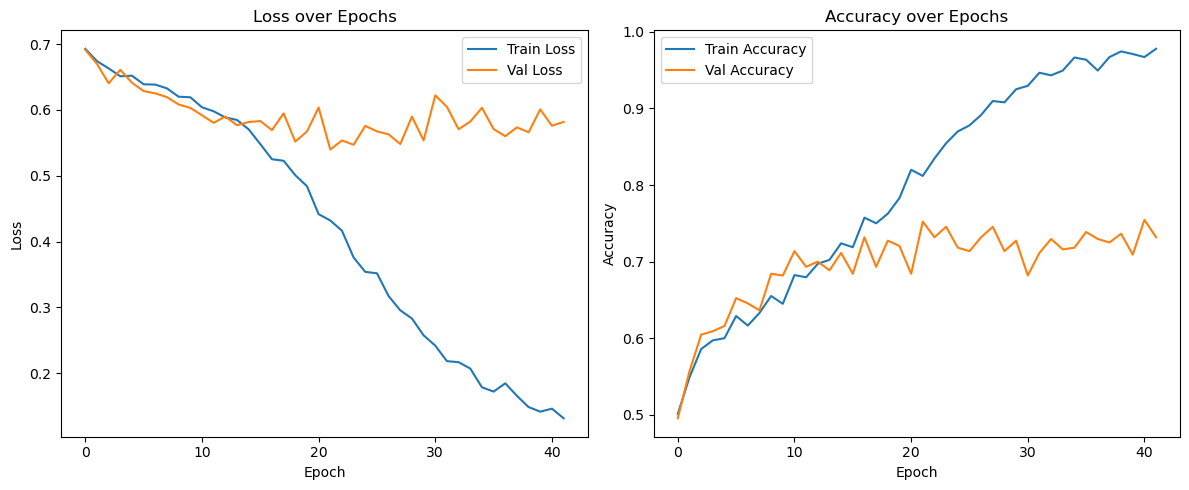

Validation accuracy: 0.7318


In [ ]:

# Suggest hyperparameters
lr = 4.08367006057259e-05
weight_decay = 0.008757687339341956
opt_cls = torch.optim.Adam
# use_bn        = trial.suggest_categorical("use_bn", [True, False])
dropout_rate  = 0.3357751894656019
# Build and train model
model = SiameseNetwork(fc1_dim=12,dropout_rate=dropout_rate)
model = train_model(
    model, train_loader, val_loader, device,
    lr, opt_cls, weight_decay, num_epochs=200, patience=20
)

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for (x1, x2), labels in val_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).float()
        preds = model(x1, x2).squeeze()
        predicted = (preds >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy:.4f}")


In [ ]:
def predict(model, test_loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct, total = 0, 0

    print("Running predictions on test set...")

    with torch.no_grad():
        for i, ((x1, x2), labels) in enumerate(test_loader):
            x1, x2 = x1.to(device), x2.to(device)
            labels = labels.to(device).float()

            preds = model(x1, x2).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            print(f"Batch {i + 1}/{len(test_loader)} — Batch Accuracy: {batch_correct / labels.size(0):.4f}")

    final_acc = correct / total
    print(f"\nFinal Test Accuracy: {final_acc:.4f}")
    return all_preds, all_labels


predict(model, test_loader)

Running predictions on test set...
Batch 1/32 — Batch Accuracy: 0.6250
Batch 2/32 — Batch Accuracy: 0.5312
Batch 3/32 — Batch Accuracy: 0.6250
Batch 4/32 — Batch Accuracy: 0.7500
Batch 5/32 — Batch Accuracy: 0.5625
Batch 6/32 — Batch Accuracy: 0.5938
Batch 7/32 — Batch Accuracy: 0.5625
Batch 8/32 — Batch Accuracy: 0.7188
Batch 9/32 — Batch Accuracy: 0.5938
Batch 10/32 — Batch Accuracy: 0.6562
Batch 11/32 — Batch Accuracy: 0.7188
Batch 12/32 — Batch Accuracy: 0.6875
Batch 13/32 — Batch Accuracy: 0.7812
Batch 14/32 — Batch Accuracy: 0.5625
Batch 15/32 — Batch Accuracy: 0.6875
Batch 16/32 — Batch Accuracy: 0.6250
Batch 17/32 — Batch Accuracy: 0.5625
Batch 18/32 — Batch Accuracy: 0.7812
Batch 19/32 — Batch Accuracy: 0.6875
Batch 20/32 — Batch Accuracy: 0.7500
Batch 21/32 — Batch Accuracy: 0.9062
Batch 22/32 — Batch Accuracy: 0.8750
Batch 23/32 — Batch Accuracy: 0.6250
Batch 24/32 — Batch Accuracy: 0.7812
Batch 25/32 — Batch Accuracy: 0.6875
Batch 26/32 — Batch Accuracy: 0.8438
Batch 27/32 

([0.79073787,
  0.09655029,
  0.7224921,
  0.80153704,
  0.66279864,
  0.32694355,
  0.6361623,
  0.5687515,
  0.39124724,
  0.6355565,
  0.96034944,
  0.8390884,
  0.27224326,
  0.6877307,
  0.39825225,
  0.8822516,
  0.4296161,
  0.6219324,
  0.71578723,
  0.8639993,
  0.66467804,
  0.3366569,
  0.23258835,
  0.9275755,
  0.10019302,
  0.32293957,
  0.9885014,
  0.36297104,
  0.06250593,
  0.6034641,
  0.9289354,
  0.8049488,
  0.22029465,
  0.76750064,
  0.73549634,
  0.5312651,
  0.9020766,
  0.87214637,
  0.27757916,
  0.9274355,
  0.5261933,
  0.46241012,
  0.64801437,
  0.6859081,
  0.56225616,
  0.42102185,
  0.60577273,
  0.3888176,
  0.3275545,
  0.39622253,
  0.4350203,
  0.958998,
  0.71658087,
  0.6054589,
  0.13504805,
  0.017931664,
  0.14899433,
  0.7595754,
  0.41043916,
  0.1181172,
  0.09664639,
  0.17415543,
  0.95348877,
  0.9318222,
  0.49282357,
  0.82199574,
  0.32289442,
  0.59025764,
  0.89831865,
  0.21485278,
  0.8557002,
  0.845352,
  0.016327273,
  0.98818